In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from math import radians, sin, cos, sqrt, atan2

In [ ]:
pd.set_option('display.max_columns', None)  # Set the maximum number of columns to display to None
pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display to None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/'My Drive'/YVW/new_job2.xlsx .

In [ ]:
# Read the data from an Excel file
data = pd.read_excel('new_job2.xlsx')

# Print Sensor data
data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label
0,2023,4,1,0,0,91.393029,13.095120,95.394749,10.582292,57.750720,2.331083,56.177239,11.0625,96.328125,52.81250,14.945995,NaN,NaN,NaN,NaN,0
1,2023,4,1,0,5,90.903227,13.046548,95.394749,11.197309,57.750720,2.331083,56.177239,11.3125,96.890625,52.75000,15.262439,NaN,NaN,NaN,NaN,0
2,2023,4,1,0,10,90.323462,12.389993,94.926688,10.691623,57.451958,2.035655,56.276827,11.1250,96.140625,52.53125,13.992271,NaN,NaN,NaN,NaN,0
3,2023,4,1,0,15,90.463405,11.849278,95.384790,10.127473,57.800514,2.057267,56.456084,11.1250,96.515625,52.81250,12.909018,NaN,NaN,NaN,NaN,0
4,2023,4,1,0,20,90.363446,12.919364,95.215491,10.293949,57.750720,3.145877,56.466043,11.0000,96.890625,52.59375,15.359190,NaN,NaN,NaN,NaN,0


In [ ]:
# Filter the dataset where label == 1
leakage_data = data[data['label'] == 1]

In [ ]:
# Sensor coordinates
sensor_coords = {
    'd_WMS0117': (-37.758, 145.135),
    'd_WMS0103': (-37.768, 145.131),
    'd_WMS0104': (-37.767, 145.119),
    'd_WMS0116': (-37.767, 145.141),
    'd_WBS628': (-37.758, 145.118)
}

# Convert sensor coordinates to a list of tuples
sensor_coordinates = list(sensor_coords.values())

In [ ]:
sensor_coordinates

[(-37.758, 145.135),
 (-37.768, 145.131),
 (-37.767, 145.119),
 (-37.767, 145.141),
 (-37.758, 145.118)]

In [ ]:
leakage_data['WMS0117_x'] = sensor_coordinates[0][0]
leakage_data['WMS0117_y'] = sensor_coordinates[0][1]
leakage_data['WMS0103_x'] = sensor_coordinates[1][0]
leakage_data['WMS0103_y'] = sensor_coordinates[1][1]
leakage_data['WMS0104_x'] = sensor_coordinates[2][0]
leakage_data['WMS0104_y']= sensor_coordinates[2][1]
leakage_data['WMS0116_x']= sensor_coordinates[3][0]
leakage_data['WMS0116_y']= sensor_coordinates[3][1]
leakage_data['WBS628_x']= sensor_coordinates[4][0]
leakage_data['WBS628_y']= sensor_coordinates[4][1]

In [ ]:
# Helper function to calculate Euclidean distance between two points
def euclidean_distance(lat1, lon1, lat2, lon2):
    # Convert lat/lon differences into Cartesian space (approximation)
    x_diff = (lon2 - lon1)
    y_diff = (lat2 - lat1)
    return np.sqrt(x_diff**2 + y_diff**2)

In [ ]:
def engineer_features(df):
    # Flow and pressure sensor lists
    flow_sensors = ['WMS0103.A3_F', 'WMS0104.A3_F', 'WMS0116.A3_F', 'WBS628.A3_F']
    pressure_sensors = ['WMS0117','WMS0103.A3_P', 'WMS0104.A3_P', 'WMS0116.A3_P', 'WBS628.A3_P1', 'WBS628.A3_P2']

    # Create flow ratio features between all pairs of flow sensors
    for i in range(len(flow_sensors)):
        for j in range(i+1, len(flow_sensors)):
            s1, s2 = flow_sensors[i], flow_sensors[j]
            if s1 in df.columns and s2 in df.columns:
                df[f'{s1}_{s2}_flow_ratio'] = df[s1] / df[s2]

    # Create pressure difference features between all pairs of pressure sensors
    for i in range(len(pressure_sensors)):
        for j in range(i+1, len(pressure_sensors)):
            s1, s2 = pressure_sensors[i], pressure_sensors[j]
            if s1 in df.columns and s2 in df.columns:
                df[f'{s1}_{s2}_pressure_diff'] = df[s1] - df[s2]

    # Define the central point of the sensor network (mean lat/lon)
    sensors_lat_cols = [col for col in df.columns if col.endswith('_y')]
    sensors_lon_cols = [col for col in df.columns if col.endswith('_x')]

    center_lat = df[sensors_lat_cols].mean().mean()
    center_lon = df[sensors_lon_cols].mean().mean()

    # Calculate distance from the center for each sensor using Euclidean distance
    for lat_col, lon_col in zip(sensors_lat_cols, sensors_lon_cols):
        sensor = lat_col.split('_')[0]  # Extract sensor name
        df[f'{sensor}_dist_from_center'] = df.apply(
            lambda row: euclidean_distance(center_lat, center_lon, row[lat_col], row[lon_col]),
            axis=1
        )

    return df, center_lat, center_lon

# Apply feature engineering to the dataset
leak_data, center_lat, center_lon = engineer_features(leakage_data)


In [ ]:
print(data.head())

   year  month  day  hour  minute    WMS0117  WMS0103.A3_F  WMS0103.A3_P  \
0  2023      4    1     0       0  91.393029     13.095120     95.394749   
1  2023      4    1     0       5  90.903227     13.046548     95.394749   
2  2023      4    1     0      10  90.323462     12.389993     94.926688   
3  2023      4    1     0      15  90.463405     11.849278     95.384790   
4  2023      4    1     0      20  90.363446     12.919364     95.215491   

   WMS0104.A3_F  WMS0104.A3_P  WMS0116.A3_F  WMS0116.A3_P  WBS628.A3_F  \
0     10.582292     57.750720      2.331083     56.177239      11.0625   
1     11.197309     57.750720      2.331083     56.177239      11.3125   
2     10.691623     57.451958      2.035655     56.276827      11.1250   
3     10.127473     57.800514      2.057267     56.456084      11.1250   
4     10.293949     57.750720      3.145877     56.466043      11.0000   

   WBS628.A3_P1  WBS628.A3_P2  DMA_Formula  job_id  Latitude  Longitude  \
0     96.328125      52

In [ ]:
leak_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label,WMS0117_x,WMS0117_y,WMS0103_x,WMS0103_y,WMS0104_x,WMS0104_y,WMS0116_x,WMS0116_y,WBS628_x,WBS628_y,WMS0103.A3_F_WMS0104.A3_F_flow_ratio,WMS0103.A3_F_WMS0116.A3_F_flow_ratio,WMS0103.A3_F_WBS628.A3_F_flow_ratio,WMS0104.A3_F_WMS0116.A3_F_flow_ratio,WMS0104.A3_F_WBS628.A3_F_flow_ratio,WMS0116.A3_F_WBS628.A3_F_flow_ratio,WMS0117_WMS0103.A3_P_pressure_diff,WMS0117_WMS0104.A3_P_pressure_diff,WMS0117_WMS0116.A3_P_pressure_diff,WMS0117_WBS628.A3_P1_pressure_diff,WMS0117_WBS628.A3_P2_pressure_diff,WMS0103.A3_P_WMS0104.A3_P_pressure_diff,WMS0103.A3_P_WMS0116.A3_P_pressure_diff,WMS0103.A3_P_WBS628.A3_P1_pressure_diff,WMS0103.A3_P_WBS628.A3_P2_pressure_diff,WMS0104.A3_P_WMS0116.A3_P_pressure_diff,WMS0104.A3_P_WBS628.A3_P1_pressure_diff,WMS0104.A3_P_WBS628.A3_P2_pressure_diff,WMS0116.A3_P_WBS628.A3_P1_pressure_diff,WMS0116.A3_P_WBS628.A3_P2_pressure_diff,WBS628.A3_P1_WBS628.A3_P2_pressure_diff,WMS0117_dist_from_center,WMS0103_dist_from_center,WMS0104_dist_from_center,WMS0116_dist_from_center,WBS628_dist_from_center
732,2023,4,3,13,0,91.173118,19.074255,94.896812,13.213749,57.382247,4.245909,57.412123,12.9375,96.093750,52.0000,23.596413,8082462.0,-37.757291,145.12543,3.0,1,-37.758,145.135,-37.768,145.131,-37.767,145.119,-37.767,145.141,-37.758,145.118,1.443516,4.492385,1.474339,3.112113,1.021353,0.328186,-3.723694,33.790871,33.760995,-4.920632,39.173118,37.514565,37.484689,-1.196938,42.896812,-0.029876,-38.711503,5.382247,-38.681627,5.412123,44.093750,0.008355,0.004919,0.010373,0.012665,0.012166
733,2023,4,3,13,5,91.852843,20.282167,94.896812,13.213749,57.382247,3.502653,57.412123,12.8125,95.953125,52.0000,24.186070,8082462.0,-37.757291,145.12543,3.0,1,-37.758,145.135,-37.768,145.131,-37.767,145.119,-37.767,145.141,-37.758,145.118,1.534929,5.790515,1.582998,3.772497,1.031317,0.273378,-3.043969,34.470596,34.440720,-4.100282,39.852843,37.514565,37.484689,-1.056313,42.896812,-0.029876,-38.570878,5.382247,-38.541002,5.412123,43.953125,0.008355,0.004919,0.010373,0.012665,0.012166
734,2023,4,3,13,10,90.593353,21.090418,94.896812,13.589628,56.525795,3.983783,57.302577,13.0625,96.421875,52.0625,25.601329,8082462.0,-37.757291,145.12543,3.0,1,-37.758,145.135,-37.768,145.131,-37.767,145.119,-37.767,145.141,-37.758,145.118,1.551950,5.294069,1.614577,3.411237,1.040354,0.304979,-4.303459,34.067557,33.290776,-5.828522,38.530853,38.371016,37.594235,-1.525063,42.834312,-0.776782,-39.896080,4.463295,-39.119298,5.240077,44.359375,0.008355,0.004919,0.010373,0.012665,0.012166
735,2023,4,3,13,15,90.993191,20.886726,95.374831,14.648073,57.043650,3.567081,57.163154,15.8125,95.906250,50.7500,23.289381,8082462.0,-37.757291,145.12543,3.0,1,-37.758,145.135,-37.768,145.131,-37.767,145.119,-37.767,145.141,-37.758,145.118,1.425903,5.855411,1.320900,4.106459,0.926360,0.225586,-4.381640,33.949541,33.830036,-4.913059,40.243191,38.331181,38.211677,-0.531419,44.624831,-0.119505,-38.862600,6.293650,-38.743096,6.413154,45.156250,0.008355,0.004919,0.010373,0.012665,0.012166
736,2023,4,3,13,20,91.632932,19.812401,95.135821,16.497705,56.635341,3.742476,57.710885,12.2500,96.375000,52.1875,27.802583,8082462.0,-37.757291,145.12543,3.0,1,-37.758,145.135,-37.768,145.131,-37.767,145.119,-37.767,145.141,-37.758,145.118,1.200919,5.293928,1.617339,4.408232,1.346751,0.305508,-3.502889,34.997591,33.922047,-4.742068,39.445432,38.500480,37.424936,-1.239179,42.948321,-1.075544,-39.739659,4.447841,-38.664115,5.523385,44.187500,0.008355,0.004919,0.010373,0.012665,0.012166


In [ ]:
# List of features to use
features = []


In [ ]:
# List of columns you want to exclude
exclude_columns = ['year', 'day', 'month','minute','hour','job_id','Latitude','Longitude','Priority','label']  # replace with actual column names

# Get the list of column names except for the ones to exclude
remaining_columns = leak_data.drop(columns=exclude_columns).columns.tolist()

# Add the remaining columns to the features array
features = remaining_columns


In [ ]:
print(len(features))

47


In [ ]:
print(len(leak_data.dtypes))

57


In [ ]:
num_null_values = leak_data.isnull().sum()

print(num_null_values)

year                                       0
month                                      0
day                                        0
hour                                       0
minute                                     0
WMS0117                                    0
WMS0103.A3_F                               0
WMS0103.A3_P                               0
WMS0104.A3_F                               0
WMS0104.A3_P                               0
WMS0116.A3_F                               0
WMS0116.A3_P                               0
WBS628.A3_F                                0
WBS628.A3_P1                               0
WBS628.A3_P2                               0
DMA_Formula                                0
job_id                                     0
Latitude                                   0
Longitude                                  0
Priority                                   0
label                                      0
WMS0117_x                                  0
WMS0117_y 

In [ ]:
# Assuming 'leak_data' contains 'job_id', 'Priority', 'Latitude', and 'Longitude'
job_ids = leak_data[['job_id', 'Priority']]
# Prepare the feature matrix (X) and target variables (y)
X = leak_data[features]
y = leak_data[['Latitude', 'Longitude']]


In [ ]:
# Scale the features
#x_scaler = StandardScaler()

# Define the path in Google Drive where you want to save the scaler
#scaler_path = '/content/drive/My Drive/YVW/x_scaler.pkl'

# Save the scaler to a file in Google Drive
#joblib.dump(x_scaler, scaler_path)
#leakage_data[features_to_scale] = x_scaler.fit_transform(leakage_data[features_to_scale])

In [ ]:
# Split data into training and test sets and include job_id and Priority
X_train, X_test, y_train, y_test, job_ids_train, job_ids_test = train_test_split(
    X, y, job_ids, test_size=0.2, random_state=0
)

In [ ]:
# Scale the features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [ ]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.fit_transform(y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_complex_nn_model(input_shape):
    model = Sequential([

        # Second dense layer
        Dense(256, input_shape=(input_shape,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        # Third dense layer
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        # Fourth dense layer
        Dense(32),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        # Fifth dense layer for further complexity
        Dense(16, activation='relu'),

        # Output layer (x_cart and y_cart)
        Dense(2)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [ ]:
nn_model = build_complex_nn_model(X_train_scaled.shape[1])
history = nn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Save the entire model to a file
nn_model.save('/content/drive/My Drive/YVW/10values_job2FE_model.h5')

Epoch 1/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.1055 - val_loss: 0.9591
Epoch 2/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9467 - val_loss: 0.9633
Epoch 3/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9361 - val_loss: 0.9366
Epoch 4/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9197 - val_loss: 0.9124
Epoch 5/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9164 - val_loss: 0.9510
Epoch 6/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9138 - val_loss: 0.9546
Epoch 7/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9038 - val_loss: 0.9060
Epoch 8/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9021 - val_loss: 0.9108
Epoch 9/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8896 - val_loss: 0.9582
Epoch 10/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8893 - val_loss: 0.9014
Epoch 11/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8913 - val_loss: 0.9010
Epoch 12/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

In [ ]:
y_pred = nn_model.predict(X_test_scaled)

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
nn_predictions= scaler_y.inverse_transform(y_pred)


In [ ]:
nn_mae = mean_absolute_error(y_test[['Latitude', 'Longitude']], nn_predictions)
print(f"Neural Network MAE: {nn_mae}")

from sklearn.metrics import mean_squared_error

nn_rmse = np.sqrt(mean_squared_error(y_test[['Latitude', 'Longitude']], nn_predictions))
print(f"Neural Network RMSE: {nn_rmse}")


Neural Network MAE: 0.00446607360099148
Neural Network RMSE: 0.005873198335950077


In [ ]:
df_predictions = pd.DataFrame(nn_predictions, columns = ('Latitude','Longitude'))

In [ ]:
# Extract actual latitude and longitude from y_test
actual_latitude = y_test['Latitude'].reset_index(drop=True)
actual_longitude = y_test['Longitude'].reset_index(drop=True)

# Create a DataFrame for actual and predicted values
combined_results = pd.DataFrame({
    'job_id': job_ids_test['job_id'].reset_index(drop=True),
    'Priority': job_ids_test['Priority'].reset_index(drop=True),
    'actual_latitude': actual_latitude,
    'actual_longitude': actual_longitude,
    'predicted_latitude': df_predictions['Latitude'].reset_index(drop=True),
    'predicted_longitude': df_predictions['Longitude'].reset_index(drop=True)
})
# Check the combined DataFrame
print(combined_results.head())

      job_id  Priority  actual_latitude  actual_longitude  predicted_latitude  \
0  8339041.0       3.0       -37.759634        145.118820          -37.759319   
1  8348088.0       3.0       -37.758770        145.134951          -37.758835   
2  8231996.0       3.0       -37.757644        145.129883          -37.758110   
3  8201945.0       3.0       -37.757649        145.132448          -37.758301   
4  8325264.0       3.0       -37.766951        145.139956          -37.759544   

   predicted_longitude  
0           145.130768  
1           145.132660  
2           145.128555  
3           145.130981  
4           145.131042  


In [ ]:
pip install contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.4 MB/s eta 0:00:00


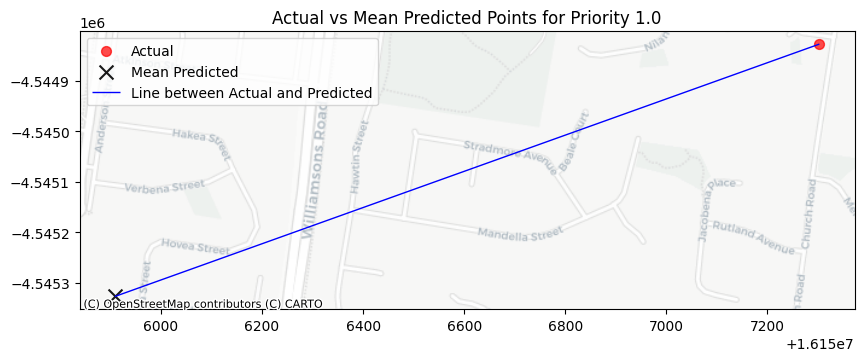

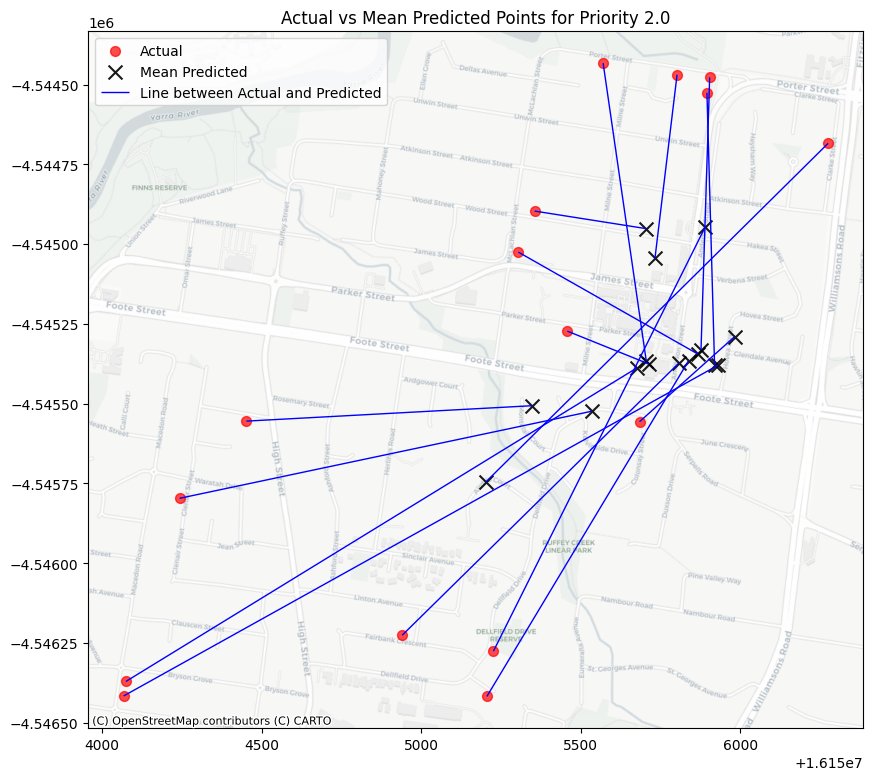

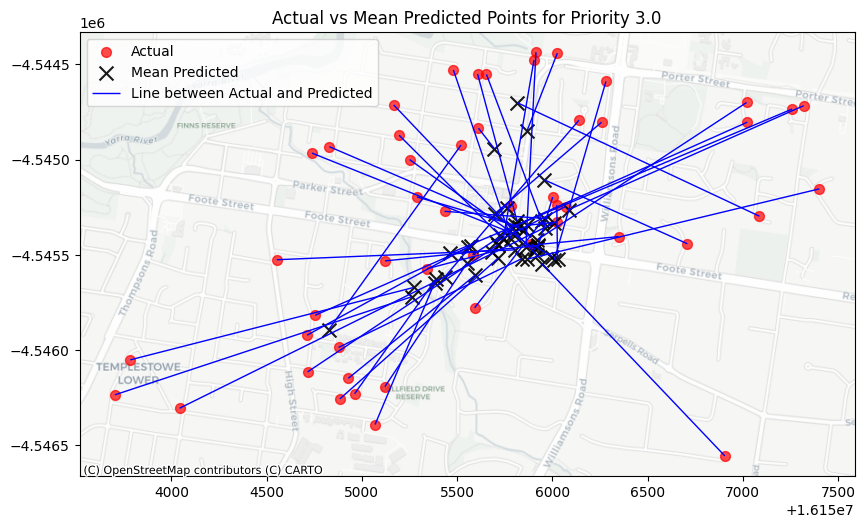

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx

# Function to plot actual points, mean predicted points, and lines between them for each priority
def plot_jobs_by_priority(result_df):
    # Loop through each priority level
    for priority, priority_data in result_df.groupby('Priority'):
        # List to store GeoDataFrames for actual, predicted, and lines
        actual_points = []
        predicted_means = []
        lines = []

        # Loop through each job_id in the current priority group
        for job_id, job_data in priority_data.groupby('job_id'):
            # Get the actual point
            actual_lat = job_data['actual_latitude'].values[0]
            actual_lon = job_data['actual_longitude'].values[0]
            actual_point = Point(actual_lon, actual_lat)
            actual_points.append(actual_point)

            # Calculate mean predicted latitude and longitude
            lat_mean = job_data['predicted_latitude'].mean()
            lon_mean = job_data['predicted_longitude'].mean()
            predicted_point = Point(lon_mean, lat_mean)
            predicted_means.append(predicted_point)

            # Create a line between the actual point and mean predicted point
            line = LineString([actual_point, predicted_point])
            lines.append(line)

        # Convert actual points to GeoDataFrame
        gdf_actual = gpd.GeoDataFrame(geometry=actual_points, crs="EPSG:4326")

        # Convert predicted mean points to GeoDataFrame
        gdf_predicted_means = gpd.GeoDataFrame(geometry=predicted_means, crs="EPSG:4326")

        # Convert lines to GeoDataFrame
        gdf_lines = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

        # Convert all to Web Mercator for basemap overlay
        gdf_actual = gdf_actual.to_crs(epsg=3857)
        gdf_predicted_means = gdf_predicted_means.to_crs(epsg=3857)
        gdf_lines = gdf_lines.to_crs(epsg=3857)

        # Plot the points and lines on a map for this priority level
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot actual points (red)
        gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual', alpha=0.7)

        # Plot predicted mean points (black)
        gdf_predicted_means.plot(ax=ax, marker='x', color='black', markersize=100, label='Mean Predicted', alpha=0.9)

        # Plot lines between actual and predicted mean points
        gdf_lines.plot(ax=ax, color='blue', linewidth=1, label='Line between Actual and Predicted')

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

        # Title and legend
        ax.set_title(f"Actual vs Mean Predicted Points for Priority {priority}")
        plt.legend()
        plt.show()

# Call the function to plot the charts for each priority
plot_jobs_by_priority(combined_results)

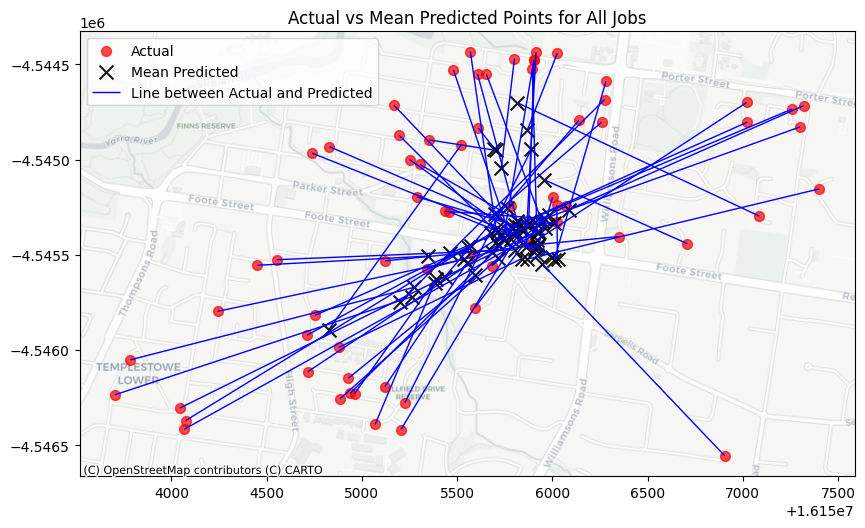

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx

# Function to plot actual points, mean predicted points, and lines between them
def plot_all_jobs_on_map(result_df, title):
    # List to store GeoDataFrames for actual, predicted, and lines
    actual_points = []
    predicted_means = []
    lines = []

    # Loop through each job_id
    for job_id, job_data in result_df.groupby('job_id'):
        # Get the actual point
        actual_lat = job_data['actual_latitude'].values[0]
        actual_lon = job_data['actual_longitude'].values[0]
        actual_point = Point(actual_lon, actual_lat)
        actual_points.append(actual_point)

        # Calculate mean predicted latitude and longitude
        lat_mean = job_data['predicted_latitude'].mean()
        lon_mean = job_data['predicted_longitude'].mean()
        predicted_point = Point(lon_mean, lat_mean)
        predicted_means.append(predicted_point)

        # Create a line between the actual point and mean predicted point
        line = LineString([actual_point, predicted_point])
        lines.append(line)

    # Convert actual points to GeoDataFrame
    gdf_actual = gpd.GeoDataFrame(geometry=actual_points, crs="EPSG:4326")

    # Convert predicted mean points to GeoDataFrame
    gdf_predicted_means = gpd.GeoDataFrame(geometry=predicted_means, crs="EPSG:4326")

    # Convert lines to GeoDataFrame
    gdf_lines = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

    # Convert all to Web Mercator for basemap overlay
    gdf_actual = gdf_actual.to_crs(epsg=3857)
    gdf_predicted_means = gdf_predicted_means.to_crs(epsg=3857)
    gdf_lines = gdf_lines.to_crs(epsg=3857)

    # Plot the points and lines on a map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot actual points (red)
    gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual', alpha=0.7)

    # Plot predicted mean points (black)
    gdf_predicted_means.plot(ax=ax, marker='x', color='black', markersize=100, label='Mean Predicted', alpha=0.9)

    # Plot lines between actual and predicted mean points
    gdf_lines.plot(ax=ax, color='blue', linewidth=1, label='Line between Actual and Predicted')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Title and legend
    ax.set_title(title)
    plt.legend()
    plt.show()

# Call the function to plot all jobs on a single map
plot_all_jobs_on_map(combined_results, title="Actual vs Mean Predicted Points for All Jobs")


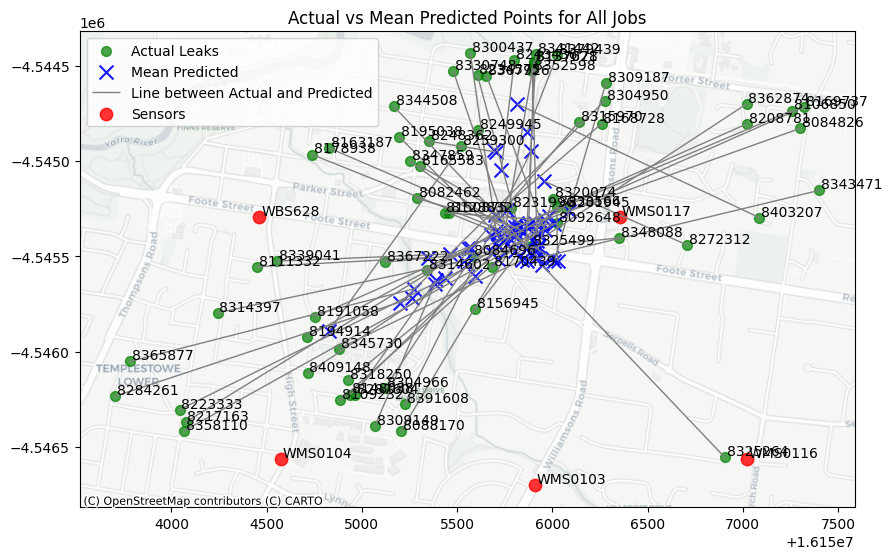

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx
from pyproj import Transformer

# Function to plot actual points, mean predicted points, lines, sensors, and job_id labels
def plot_all_jobs_on_map(result_df, sensor_coords, title):
    # List to store GeoDataFrames for actual, predicted, and lines
    actual_points = []
    predicted_means = []
    lines = []
    job_ids = []

    # Loop through each job_id
    for job_id, job_data in result_df.groupby('job_id'):
        # Get the actual point
        actual_lat = job_data['actual_latitude'].values[0]
        actual_lon = job_data['actual_longitude'].values[0]
        actual_point = Point(actual_lon, actual_lat)
        actual_points.append(actual_point)

        # Calculate mean predicted latitude and longitude
        lat_mean = job_data['predicted_latitude'].mean()
        lon_mean = job_data['predicted_longitude'].mean()
        predicted_point = Point(lon_mean, lat_mean)
        predicted_means.append(predicted_point)

        # Create a line between the actual point and mean predicted point
        line = LineString([actual_point, predicted_point])
        lines.append(line)

        # Store job_id
        job_ids.append(job_id)

    # Convert actual points to GeoDataFrame
    gdf_actual = gpd.GeoDataFrame(geometry=actual_points, crs="EPSG:4326")

    # Convert predicted mean points to GeoDataFrame
    gdf_predicted_means = gpd.GeoDataFrame(geometry=predicted_means, crs="EPSG:4326")

    # Convert lines to GeoDataFrame
    gdf_lines = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

    # Convert all to Web Mercator for basemap overlay
    gdf_actual = gdf_actual.to_crs(epsg=3857)
    gdf_predicted_means = gdf_predicted_means.to_crs(epsg=3857)
    gdf_lines = gdf_lines.to_crs(epsg=3857)

    # Plot the points and lines on a map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot actual points (green)
    gdf_actual.plot(ax=ax, marker='o', color='green', markersize=50, label='Actual Leaks', alpha=0.7)

    # Plot predicted mean points (blue)
    gdf_predicted_means.plot(ax=ax, marker='x', color='blue', markersize=100, label='Mean Predicted', alpha=0.9)

    # Plot lines between actual and predicted mean points (grey)
    gdf_lines.plot(ax=ax, color='grey', linewidth=1, label='Line between Actual and Predicted')

    # Convert sensor coordinates to Web Mercator (EPSG:3857) using pyproj
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    sensor_points = []
    for sensor_name, (lat, lon) in sensor_coords.items():
        x, y = transformer.transform(lon, lat)
        sensor_points.append(Point(x, y))

    # Create a GeoDataFrame for the sensors
    gdf_sensors = gpd.GeoDataFrame(geometry=sensor_points, crs="EPSG:3857")
    gdf_sensors.plot(ax=ax, marker='o', color='red', markersize=80, label='Sensors', alpha=0.8)

    # Plot sensor names near each sensor point
    for point, (sensor_name, _) in zip(sensor_points, sensor_coords.items()):
        sensor_name_clean = sensor_name.replace('d_', '')  # Remove 'd_' from sensor name
        ax.text(point.x + 10, point.y + 10, sensor_name_clean, fontsize=10, color='black')

    # Plot job_ids next to the actual leak points without the decimal
    for point, job_id in zip(gdf_actual.geometry, job_ids):
        # Convert job_id to int, handling any non-integer formats
        try:
            job_id_int = int(float(job_id))  # Convert to float first in case it's in string format with decimal
        except ValueError:
            job_id_int = job_id  # If it fails, just keep the original value

        # Display the job_id on the plot
        ax.text(point.x + 10, point.y + 10, job_id_int, fontsize=10, color='black')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Title and legend
    ax.set_title(title)
    plt.legend()
    plt.show()

# Call the function to plot all jobs on a single map, including sensors
plot_all_jobs_on_map(combined_results, sensor_coords, title="Actual vs Mean Predicted Points for All Jobs")


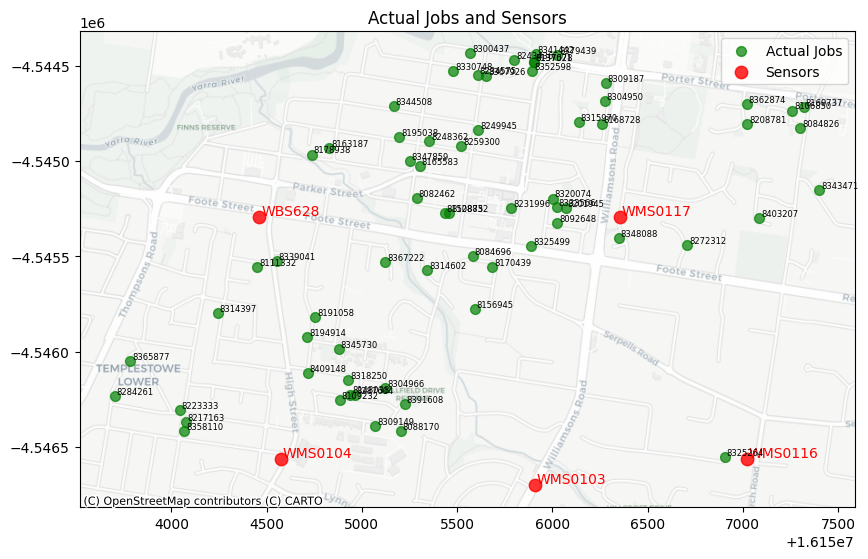

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from pyproj import Transformer

# Function to plot actual jobs and sensors with their names
def plot_jobs_and_sensors(result_df, sensor_coords, title):
    # List to store GeoDataFrame for actual points
    actual_points = []
    job_ids = []

    # Loop through each job_id
    for job_id, job_data in result_df.groupby('job_id'):
        # Get the actual point
        actual_lat = job_data['actual_latitude'].values[0]
        actual_lon = job_data['actual_longitude'].values[0]
        actual_point = Point(actual_lon, actual_lat)
        actual_points.append(actual_point)

        # Store job_id
        job_ids.append(job_id)

    # Convert actual points to GeoDataFrame
    gdf_actual = gpd.GeoDataFrame(geometry=actual_points, crs="EPSG:4326")

    # Convert actual points to Web Mercator for basemap overlay
    gdf_actual = gdf_actual.to_crs(epsg=3857)

    # Plot the actual jobs and sensors on a map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot actual points (green) with job_ids
    gdf_actual.plot(ax=ax, marker='o', color='green', markersize=50, label='Actual Jobs', alpha=0.7)

    # Convert sensor coordinates to Web Mercator (EPSG:3857) using pyproj
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    sensor_points = []
    for sensor_name, (lat, lon) in sensor_coords.items():
        x, y = transformer.transform(lon, lat)
        sensor_points.append(Point(x, y))

    # Create a GeoDataFrame for the sensors
    gdf_sensors = gpd.GeoDataFrame(geometry=sensor_points, crs="EPSG:3857")
    gdf_sensors.plot(ax=ax, marker='o', color='red', markersize=80, label='Sensors', alpha=0.8)

    # Plot sensor names near each sensor point
    for point, (sensor_name, _) in zip(sensor_points, sensor_coords.items()):
        sensor_name_clean = sensor_name.replace('d_', '')  # Remove 'd_' from sensor name
        ax.text(point.x + 10, point.y + 10, sensor_name_clean, fontsize=10, color='red')

    # Plot job_ids next to the actual leak points without the decimal
    for point, job_id in zip(gdf_actual.geometry, job_ids):
        # Convert job_id to int, handling any non-integer formats
        try:
            job_id_int = int(float(job_id))  # Convert to float first in case it's in string format with decimal
        except ValueError:
            job_id_int = job_id  # If it fails, just keep the original value

        # Display the job_id on the plot
        ax.text(point.x + 10, point.y + 10,job_id_int, fontsize=6, color='black')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Title and legend
    ax.set_title(title)
    plt.legend()
    plt.show()

# Call the function to plot only actual jobs and sensors
plot_jobs_and_sensors(combined_results, sensor_coords, title="Actual Jobs and Sensors")


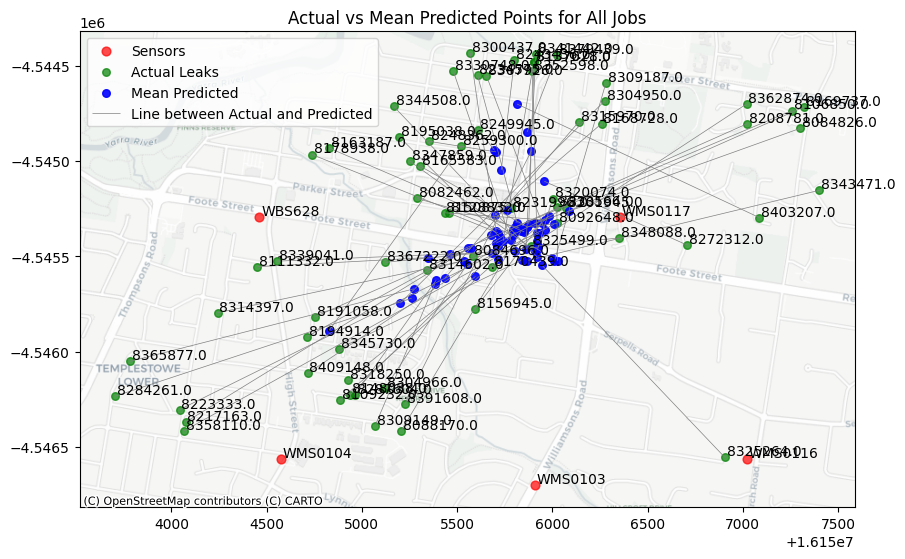

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx

# Function to plot actual points, mean predicted points, sensor locations, and lines between them
def plot_all_jobs_on_map(result_df, sensor_coords, title):
    # List to store GeoDataFrames for actual, predicted, and lines
    actual_points = []
    predicted_means = []
    lines = []
    job_ids = []  # To store the job_ids for labeling

    # Convert sensor coordinates to GeoDataFrame and clean sensor names
    sensor_names = [name.replace('d_', '') for name in sensor_coords.keys()]
    sensor_points = [Point(lon, lat) for lat, lon in sensor_coords.values()]
    gdf_sensors = gpd.GeoDataFrame(geometry=sensor_points, crs="EPSG:4326").to_crs(epsg=3857)

    # Loop through each job_id
    for job_id, job_data in result_df.groupby('job_id'):
        # Get the actual point (leak location)
        actual_lat = job_data['actual_latitude'].values[0]
        actual_lon = job_data['actual_longitude'].values[0]
        actual_point = Point(actual_lon, actual_lat)
        actual_points.append(actual_point)

        # Store job_id for labeling
        job_ids.append(job_id)

        # Calculate mean predicted latitude and longitude
        lat_mean = job_data['predicted_latitude'].mean()
        lon_mean = job_data['predicted_longitude'].mean()
        predicted_point = Point(lon_mean, lat_mean)
        predicted_means.append(predicted_point)

        # Create a line between the actual point and mean predicted point
        line = LineString([actual_point, predicted_point])
        lines.append(line)

    # Convert actual points to GeoDataFrame
    gdf_actual = gpd.GeoDataFrame(geometry=actual_points, crs="EPSG:4326")

    # Convert predicted mean points to GeoDataFrame
    gdf_predicted_means = gpd.GeoDataFrame(geometry=predicted_means, crs="EPSG:4326")

    # Convert lines to GeoDataFrame
    gdf_lines = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

    # Convert all to Web Mercator for basemap overlay
    gdf_actual = gdf_actual.to_crs(epsg=3857)
    gdf_predicted_means = gdf_predicted_means.to_crs(epsg=3857)
    gdf_lines = gdf_lines.to_crs(epsg=3857)

    # Plot the points and lines on a map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot sensor locations (red dots)
    gdf_sensors.plot(ax=ax, marker='o', color='red', markersize=40, label='Sensors', alpha=0.7)

    # Plot actual leak points (green dots)
    gdf_actual.plot(ax=ax, marker='o', color='green', markersize=30, label='Actual Leaks', alpha=0.7)

    # Plot predicted mean points (blue dots)
    gdf_predicted_means.plot(ax=ax, marker='o', color='blue', markersize=30, label='Mean Predicted', alpha=0.9)

    # Plot lines between actual and predicted mean points (grey)
    gdf_lines.plot(ax=ax, color='grey', linewidth=0.5, label='Line between Actual and Predicted')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Plot sensor names next to each sensor point
    for (point, name) in zip(gdf_sensors.geometry, sensor_names):
        ax.text(point.x + 10, point.y + 10, name, fontsize=10, color='black')

    # Plot job_ids next to the actual leak points
    for point, job_id in zip(gdf_actual.geometry, job_ids):
        ax.text(point.x + 10, point.y + 10, job_id, fontsize=10, color='black')

    # Title and legend
    ax.set_title(title)
    plt.legend()
    plt.show()

# Call the function to plot all jobs on a single map, including sensors and job_ids
plot_all_jobs_on_map(combined_results, sensor_coords, title="Actual vs Mean Predicted Points for All Jobs")


In [ ]:

# Group by job_id and priority to calculate the mean of predicted latitude and longitude
mean_predicted = combined_results.groupby(['job_id', 'Priority']).agg({
    'predicted_latitude': 'mean',
    'predicted_longitude': 'mean',
    'actual_latitude': 'first',  # Assuming all job_ids have the same actual location
    'actual_longitude': 'first'
}).reset_index()

# Display the grouped DataFrame
print(mean_predicted.head())

# Calculate the Euclidean distance for each row
mean_predicted['euclidean_distance'] = np.sqrt(
    (mean_predicted['actual_latitude'] - mean_predicted['predicted_latitude']) ** 2 +
    (mean_predicted['actual_longitude'] - mean_predicted['predicted_longitude']) ** 2
)

# Calculate the variance of the Euclidean distances
variance_euclidean_distance = mean_predicted['euclidean_distance'].var()

print(f"Variance of Euclidean distances between actual and predicted locations: {variance_euclidean_distance}")


      job_id  Priority  predicted_latitude  predicted_longitude  \
0  8082462.0       3.0          -37.758400           145.130280   
1  8084696.0       3.0          -37.758469           145.129944   
2  8084826.0       1.0          -37.758228           145.130981   
3  8088170.0       2.0          -37.758499           145.130371   
4  8092648.0       3.0          -37.758343           145.130630   

   actual_latitude  actual_longitude  
0       -37.757291        145.125430  
1       -37.759454        145.128055  
2       -37.754677        145.143522  
3       -37.765970        145.124678  
4       -37.758228        145.132048  
Variance of Euclidean distances between actual and predicted locations: 1.8287918868901455e-05
